<a href="https://colab.research.google.com/github/NaveenaK2003/Stock_Price_Prediction/blob/main/StockPrice1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load CSVs
price_df = pd.read_csv('/content/drive/MyDrive/Tesla_Price.csv')
tweet_df = pd.read_csv('/content/drive/MyDrive/Tesla.csv')

# Clean price data
price_df['Date'] = pd.to_datetime(price_df['Date'], format='%b %d, %Y', errors='coerce')
price_df['Volume'] = price_df['Volume'].str.replace(',', '').astype(float)

# Clean tweet data
tweet_df['Date'] = pd.to_datetime(tweet_df['Date']).dt.date

# Sentiment analysis
analyzer = SentimentIntensityAnalyzer()
tweet_df['Sentiment'] = tweet_df['Tweet'].astype(str).apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Average sentiment per day
daily_sentiment = tweet_df.groupby('Date')['Sentiment'].mean().reset_index()
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'])

# Merge
merged_df = pd.merge(price_df, daily_sentiment, on='Date', how='inner')
merged_df = merged_df[['Date', 'Close', 'Sentiment']].sort_values('Date')
merged_df.reset_index(drop=True, inplace=True)

# Save for modeling
merged_df.to_csv("/content/drive/MyDrive/merged.csv", index=False)

# Show preview
print(merged_df.head())

        Date   Close  Sentiment
0 2021-09-30  258.49   0.251634
1 2021-10-01  258.41   0.222412
2 2021-10-04  260.51   0.151775
3 2021-10-05  260.20   0.096692
4 2021-10-06  260.92   0.229846


In [17]:
# STEP 1: Install required libraries
!pip install vaderSentiment --quiet
!pip install tensorflow --quiet

# STEP 2: Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
import matplotlib.pyplot as plt
import seaborn as sns


In [18]:
# Upload your merged.csv file or use path if already there
df = pd.read_csv("/content/drive/MyDrive/merged.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)


In [19]:
# Scale Close and Sentiment columns
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close', 'Sentiment']])

# Target: 1 if price increases next day, else 0
movement = np.where(np.diff(scaled_data[:, 0], prepend=scaled_data[0][0]) > 0, 1, 0)

# Create windowed sequences
def create_sequences(data, labels, window=60):
    X, y = [], []
    for i in range(window, len(data) - 1):
        X.append(data[i - window:i])
        y.append(labels[i])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, movement)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [20]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # binary output
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - accuracy: 0.5963 - loss: 0.6862 - val_accuracy: 0.4857 - val_loss: 0.6933
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.5643 - loss: 0.6890 - val_accuracy: 0.5143 - val_loss: 0.6921
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - accuracy: 0.6015 - loss: 0.6693 - val_accuracy: 0.5143 - val_loss: 0.6921
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 307ms/step - accuracy: 0.5841 - loss: 0.6878 - val_accuracy: 0.5429 - val_loss: 0.6922
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - accuracy: 0.6026 - loss: 0.6741 - val_accuracy: 0.6000 - val_loss: 0.6929
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.5977 - loss: 0.6626 - val_accuracy: 0.4571 - val_loss: 0.6931
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.5951 - loss: 0.6661 - val_accuracy: 0.4857 - val_loss: 0.6963
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.5391 - loss: 0.7008 - val_accuracy: 0.4857 - val_loss:

In [21]:
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype(int)

# Metrics
acc = accuracy_score(y_test, y_pred_class)
prec = precision_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ Precision: {prec:.4f}")
print(f"✅ F1 Score: {f1:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
✅ Accuracy: 0.4857
✅ Precision: 0.4857
✅ F1 Score: 0.6538


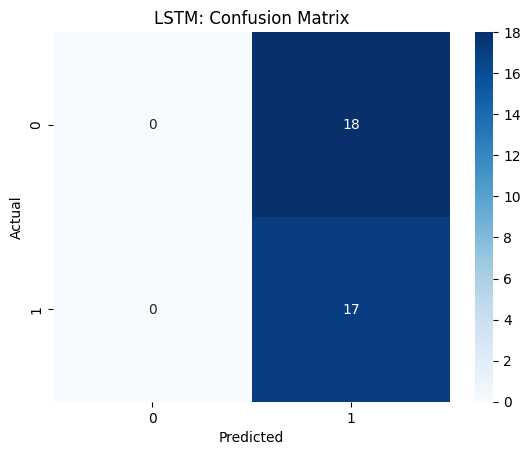

In [22]:
cm = confusion_matrix(y_test, y_pred_class)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("LSTM: Confusion Matrix")
plt.show()
